# 1. Data Wrangling and EDA

## 1.1 Imports

In [ ]:
from google.colab import files, drive
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import numpy as np
import pandas as pd
import sklearn.decomposition
import pickle
import dill
import sys

## 1.2 Initialization

In [ ]:
RANDOM_SEED = 42

In [ ]:
#mount google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#add the src folder to the search path so that modules in the src folder can be imported
sys.path.append('/content/gdrive/MyDrive/Capstone3/src')
import DataSetup

The **DataSetup.py** script contains functions that are useful for preparing the dataset. This includes setting up the folder structure and performing the train/test split.

## 1.3 Collect the Data (Lung and Colon Cancer Histopathological Images)

* Data Source: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

###1.3.1 Upload API key to connect to kaggle

In [ ]:
#upload the API key (kaggle.json)
_ = files.upload()

Saving kaggle.json to kaggle.json


### 1.3.2 Download and Unzip the dataset

In [ ]:
#function to collect and unzip the lung and colon cancer image dataset
def dataset_setup():

    #create kaggle folder, move api key to kaggle folder, set read/write access
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

    #download the dataset (lung and colon cancer histopathological images)
    ! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

    #unzip the dataset
    !unzip -q lung-and-colon-cancer-histopathological-images.zip

In [ ]:
#collect and unzip the lung and colon cancer image dataset
dataset_setup()

 99% 1.75G/1.76G [00:07<00:00, 255MB/s]
100% 1.76G/1.76G [00:07<00:00, 262MB/s]


### 1.3.3 Map image class to raw dataset folder path

In [ ]:
#map class to folder path
dict_image_paths = {
  'lung_normal':'lung_colon_image_set/lung_image_sets/lung_n/',
  'lung_aca':'lung_colon_image_set/lung_image_sets/lung_aca/',
  'lung_scc':'lung_colon_image_set/lung_image_sets/lung_scc/',
  'colon_normal':'lung_colon_image_set/colon_image_sets/colon_n/',
  'colon_aca':'lung_colon_image_set/colon_image_sets/colon_aca/'
}

## 1.4 Exploratory Data Analysis

### 1.4.1 Inspect Images

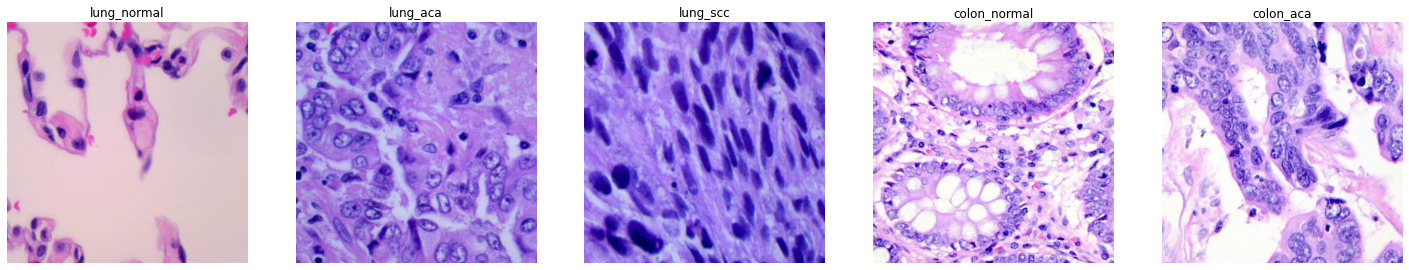

In [ ]:
#inspect an image from each class
fig, ax = plt.subplots(1,5,figsize=(25,10))
for i, item in enumerate(dict_image_paths.items()):
    img_class = item[0]
    path = item[1]
    axis = ax[i]

    path = path + os.listdir(path)[0]
    axis.imshow(plt.imread(path))
    axis.axis('off')
    axis.set_title(img_class)


### 1.4.2 Image Classes

**Class Size**

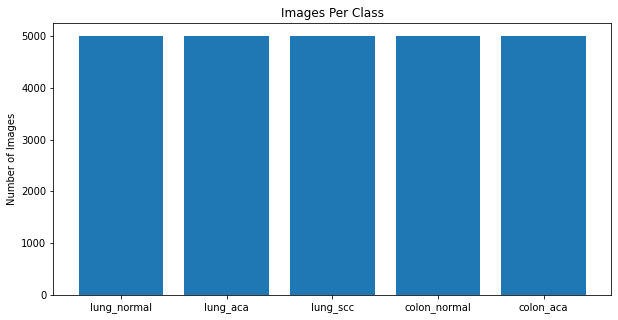

In [ ]:
#check the number of images in each class
dict_class_size = {}
for img_class, path in dict_image_paths.items():
    dict_class_size[img_class] = len(os.listdir(path))

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(dict_class_size.keys(), dict_class_size.values());
ax.set_title('Images Per Class');
ax.set_ylabel('Number of Images');

In [ ]:
#All classes are of equal size. Set the CLASS_SIZE constant
CLASS_SIZE = len(os.listdir(list(dict_image_paths.values())[0]))
print('Class Size:', CLASS_SIZE)

Class Size: 5000


**Number of Classes**

In [ ]:
#Number of classes
K = len(dict_image_paths.keys())
print('Number of Classes:', K)

Number of Classes: 5


The classes in this dataset are perfectly balanced. Therefore, accuracy can be used as a model evaluation metric. There are 5000 images per class. This value will be stored in the CLASS_SIZE constant. There are a total of 5 image classes. The constant K will be used to store the number of image classes.

### 1.4.3 Image Dimensions

In [ ]:
#check the shape of a few images
images=[]
for path in dict_image_paths.values():
    path = path + os.listdir(path)[0]
    image = plt.imread(path)
    images.append(image)
    print(path.split('/')[-1], 'shape: ', image.shape)

lungn1783.jpeg shape:  (768, 768, 3)
lungaca2495.jpeg shape:  (768, 768, 3)
lungscc2704.jpeg shape:  (768, 768, 3)
colonn1249.jpeg shape:  (768, 768, 3)
colonca2655.jpeg shape:  (768, 768, 3)


In [ ]:
#set IMAGE_SIZE constant 
IMAGE_SIZE = (images[0].shape[0], images[0].shape[1])
print('Image Size:',IMAGE_SIZE)

Image Size: (768, 768)


The images are 768x768 pixels in size with 3 colour channels (RGB format). Image size (768x768) will be stored in the "IMAGE_SIZE" constant. 

### 1.4.4 Use PCA to inspect (potential) relationships between image classes

In [ ]:
###Get the input data for PCA (randomly sample images from each class)

#set random seed
np.random.seed(RANDOM_SEED)

#number of images to sample from each class
n_per_class = 120

#select random indices to sample
rand_indices = np.random.choice(CLASS_SIZE, n_per_class, replace=False)

#lists to store images (as np arrays) and image class
selected_image_list = []
class_list = []

#retrieve the images as numpy arrays
for img_class, class_path in dict_image_paths.items():
    
    #get images for the current image class
    img_list = os.listdir(class_path)

    #select images based on random indices, return them as np arrays
    #image is cast to float32 to reduce memory usage - float64 causes colab to crash
    #images are also flattened
    current_selected_image_list = [(plt.imread(class_path + img) / 255) \
                              .astype(np.float32) \
                              .flatten()
                           for i, img in enumerate(img_list) if i in rand_indices]

    #populate the list with the class name, where list length = number of images
    current_class_list = [img_class] * len(current_selected_image_list)

    #update the image and class lists
    selected_image_list.extend(current_selected_image_list)
    class_list.extend(current_class_list)

In [ ]:
###Run PCA on the sampled images

#initialize pca model - return 2 components for plotting
pca_model = sklearn.decomposition.PCA(n_components=2)

#get the principal components
components_list = pca_model.fit_transform(selected_image_list)

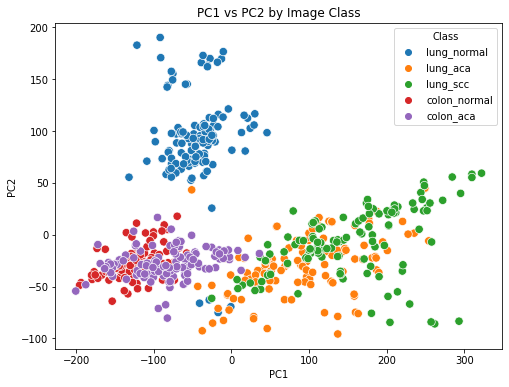

In [ ]:
###plot the PCA components to look at the relationship between image classes

#dataframe containing principal components for each image and associated class
df_components = pd.DataFrame({'PC1':components_list[:,0], 'PC2':components_list[:,1], 'Class':class_list})

#plot the principal components by category
fig, ax = plt.subplots(figsize=(8,6));
sns.scatterplot(x='PC1', y='PC2', data=df_components, hue='Class', s=70);
ax.set_title('PC1 vs PC2 by Image Class');

**PCA Analysis**

Principal Component Analysis (PCA) can be used to insepect potential relationships between image classes. PCA was used to represent the images in two dimensions, which allows relationships between image classes to be visualized on a two-dimensional plot. It is important to keep in mind that PCA only provides a rough idea of potential relationships because much of the complexity of the data will have been lost during the dimensionality reduction. With this in mind, the PCA analysis found that the five image classes were easily separated into three groups:
* Group 1: Benign Lung Tissue
* Group 2: Lung Cancer (Lung Adenocarcinoma and Lung Squamous Cell Carcinoma)
* Group 3: Colon Tissue (Benign Colon Tissue and Colon Adenocarcinoma) 

Therefore, the PCA analysis suggests the following: 
* Models will likely be highly successful at separating benign lung tissue from other tissue types. 
* Models will likely be highly successful at identifying lung cancer. However, they may run into some difficulty differentiating between the two types of lung cancer.
* Models will likely be highly successful at identifying colon tissue. However, they may be less successful at differentiating between benign and cancerous colon tissue.

It is important to keep in mind that deep learning models are highly adept at identifying complex non-linear decision boundaries. These boundaries may not be possible to visualize in two dimensions. Therefore, the problem areas identified by the PCA analysis may not pose a problem for the CNN models that will be trained.

## 1.5 Train/Test Split

### 1.5.1 Setup Folder Structure

* base folder is 'data'
* 'train' and 'test' subfolders each contain 5 subfolders - 1 for each image class

In [ ]:
#set up the folder structure for the data
train_test_path_dict = DataSetup.folder_setup(dict_image_paths.keys())

### 1.5.2 Randomly Split Raw Data into Train/Test Sets
* 90/10 train/test split

In [ ]:
###train/test split

#set the base folder to hold the train and test data
base_folder = 'data'

#indices for each class folder
indices = np.arange(0,CLASS_SIZE)

#set random seed
np.random.seed(RANDOM_SEED)

#randomly select test indices (test split size is 10%)
test_size = CLASS_SIZE // 10
test_indices = set(np.random.choice(indices, test_size, replace=False))

#train indices = the indices not in the test indices set
train_indices = set(indices) - test_indices

#ensure no overlap between train and test indices
assert len(train_indices.intersection(test_indices)) == 0

#split the images for each class into the train and test folders
for img_class, path in dict_image_paths.items():

    #image list from the source folder
    image_list = os.listdir(path)

    #destination path for training images
    destination_path = os.path.join(base_folder,'train',img_class)

    for i in train_indices:
        source_file = os.path.join(path, image_list[i])
        destination_file = os.path.join(destination_path,image_list[i])
        shutil.copyfile(source_file, destination_file)

    #detination path for test images
    destination_path = os.path.join(base_folder,'test',img_class)

    for i in test_indices:
        source_file = os.path.join(path, image_list[i])
        destination_file = os.path.join(destination_path,image_list[i])
        shutil.copyfile(source_file, destination_file)

### 1.5.3 Verify the Split 

In [ ]:
##Ensure that there are no overlapping images in the train and test sets
train_test_folders = ['train', 'test']

for img_class, path in dict_image_paths.items():
    train_path = os.path.join(base_folder,train_test_folders[0],img_class)
    test_path = os.path.join(base_folder,train_test_folders[1],img_class)

    train_set = set(os.listdir(train_path))
    test_set = set(os.listdir(test_path))

    #ensure no overlapping images
    assert len(train_set.intersection(test_set)) == 0

    #ensure train/test set size is correct
    assert len(train_set) == CLASS_SIZE * 0.9
    assert len(test_set) == CLASS_SIZE * 0.1

### 1.5.4 Get list of files in each folder for train/test split reusability

In [ ]:
###get the list of files in each folder in order to reuse the train/test split

filepath_dict = {}

#for train and test sets
for data_path in train_test_path_dict:

    #for each image class
    for img_class_path in train_test_path_dict[data_path]:
        
        #get the list of files in the folder
        filepath_dict[img_class_path] = os.listdir(img_class_path)

## 1.6 Save Reusable Resources to Google Drive

The following resources will be saved to Google Drive for reusability in the other notebooks:
* RANDOM_SEED constant
* CLASS_SIZE constant
* IMAGE_SIZE constant 
* K constant (representing the number of image classes)
* The mapping of image classes to the file path for each image class in the raw data
* The list of files in the train and test directories to ensure reusability of the train/test split.
* A function to download and unzip the data, so that repetitive code to retrieve the dataset is not required in each notebook 

In [ ]:
###save resusable resources to Google Drive

#mount google drive
drive.mount('/content/gdrive')

#folder path to save resources in google drive
save_path = '/content/gdrive/MyDrive/Capstone3/SavedResources'

#save useful constants
constants_dict = {
    'RANDOM_SEED' : RANDOM_SEED, 
    'CLASS_SIZE' : CLASS_SIZE,
    'IMAGE_SIZE' : IMAGE_SIZE,
    'K' : K,
}
if not os.path.exists(os.path.join(save_path,'constants_dict.pkl')):
    with open(os.path.join(save_path,'constants_dict.pkl'), 'wb') as file_out:
        pickle.dump(constants_dict, file_out, protocol=pickle.HIGHEST_PROTOCOL)

#save the mapping of image class to raw data file path
if not os.path.exists(os.path.join(save_path,'dict_original_image_paths.pkl')):
    with open(os.path.join(save_path,'dict_original_image_paths.pkl'), 'wb') as file_out:
        pickle.dump(dict_image_paths, file_out, protocol=pickle.HIGHEST_PROTOCOL) 

#save the list of files in each train/test directory
if not os.path.exists(os.path.join(save_path,'filepath_dict.pkl')):
    with open(os.path.join(save_path,'filepath_dict.pkl'), 'wb') as file_out:
        pickle.dump(filepath_dict, file_out, protocol=pickle.HIGHEST_PROTOCOL)

#save the function to collect and unzip the dataset
if not os.path.exists(os.path.join(save_path,'dataset_setup_function.pkl')):
    with open(os.path.join(save_path,'dataset_setup_function.pkl'), 'wb') as file_out:
        dill_function = dill.dumps(dataset_setup)
        pickle.dump(dill_function, file_out, protocol=pickle.HIGHEST_PROTOCOL)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
